## Importing required libraries

In [1]:
import numpy as np 
import pandas as pd 

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from bs4 import BeautifulSoup 

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import warnings
warnings.simplefilter("ignore")

In [2]:
# Setting matplotlib parameters for plotting

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

## Loading and Inspecting the data

In [3]:
train_df = pd.read_csv("labeledTrainData.tsv.zip", delimiter = "\t", header = 0, doublequote = False, escapechar = "\\")
train_df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [5]:
train_df.isna().sum()

id           0
sentiment    0
review       0
dtype: int64

In [6]:
# Dropping `id` column since it is not useful in analysis and modeling

train_df.drop(columns = "id", inplace = True)

In [7]:
train_df.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


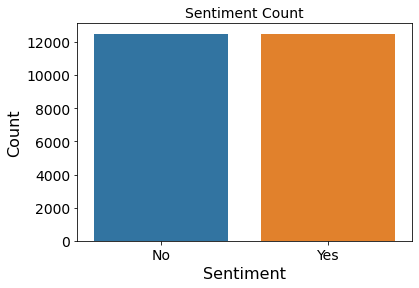

In [8]:
sns.countplot(train_df["sentiment"])
plt.xticks(ticks = [0, 1], labels = ["No", "Yes"])
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment Count")
plt.show()

In [9]:
train_len = train_df["review"].apply(len)

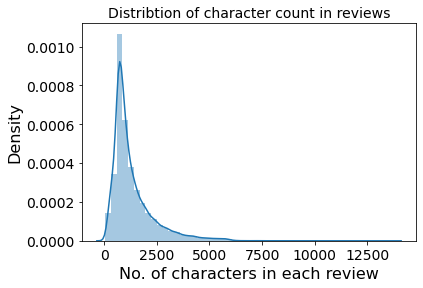

In [10]:
sns.distplot(train_len)
plt.xlabel("No. of characters in each review")
plt.title("Distribtion of character count in reviews")
plt.show()

In [11]:
train_df["num_words"] = train_df["review"].apply(lambda x: len(x.split()))

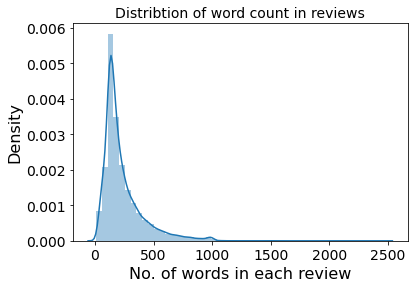

In [12]:
sns.distplot(train_df["num_words"])
plt.xlabel("No. of words in each review")
plt.title("Distribtion of word count in reviews")
plt.show()

## Text preprocessing

In [13]:
all_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [14]:
def clean_text(review):
    "Function to preprocess the reviews inorder to feed into model"
        
    clean_review = BeautifulSoup(review).get_text()
    clean_review = re.sub("[^a-zA-Z]"," ", clean_review) 
    clean_review = clean_review.lower()
    clean_review = clean_review.split()
    clean_review = [lemmatizer.lemmatize(word) for word in clean_review if not word in all_stopwords]
    
    return " ".join(clean_review)

In [15]:
train_df["clean review"] = train_df["review"].apply(clean_text)

In [16]:
train_df.head()

,sentiment,review,num_words,clean review
0,1,With all this stuff going down at the moment w...,433,stuff going moment mj started listening music ...
1,1,"""The Classic War of the Worlds"" by Timothy Hin...",158,classic war world timothy hines entertaining f...
2,0,The film starts with a manager (Nicholas Bell)...,378,film start manager nicholas bell giving welcom...
3,0,It must be assumed that those who praised this...,379,must assumed praised film greatest filmed oper...
4,1,Superbly trashy and wondrously unpretentious 8...,367,superbly trashy wondrously unpretentious explo...


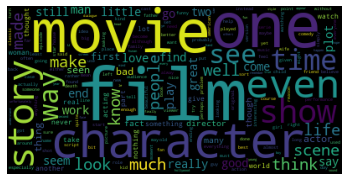

In [17]:
cloud = WordCloud().generate(train_df["clean review"].str.cat(sep = " "))
plt.imshow(cloud)
plt.axis("off")
plt.show()

## Training the model

Bag of words is a Natural Language Processing technique of text modelling. In technical terms, we can say that it is a method of feature extraction with text data. This approach is a simple and flexible way of extracting features from documents.
A bag of words is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. It is called a “bag” of words because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

One of the biggest problems with text is that it is messy and unstructured, and machine learning algorithms prefer structured, well defined fixed-length inputs and by using the Bag-of-Words technique we can convert variable-length texts into a fixed-length vector. Also, at a much granular level, the machine learning models work with numerical data rather than textual data. So to be more specific, by using the bag-of-words (BoW) technique, we convert a text into its equivalent vector of numbers.

TF-IDF for a word in a document is calculated by multiplying two different metrics:
The term frequency (TF) of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are other ways to adjust the frequency. For example, by dividing the raw count of instances of a word by either length of the document, or by the raw frequency of the most frequent word in the document. The formula to calculate Term-Frequency is<br>

**TF(i,j)=n(i,j)/Σ n(i,j)**<br>
Where,<br>
n(i,j )= number of times nth word  occurred in a document<br>
Σn(i,j) = total number of words in a document.<br>

The inverse document frequency(IDF) of the word across a set of documents. This suggests how common or rare a word is in the entire document set. The closer it is to 0, the more common is the word. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.
So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.
Multiplying these two numbers results in the TF-IDF score of a word in a document. The higher the score, the more relevant that word is in that particular document.

To put it in mathematical terms, the TF-IDF score is calculated as follows:

**IDF=1+log(N/dN)**<br>
Where<br>
N=Total number of documents in the dataset<br>
dN=total number of documents in which nth word occur<br>

Also, note that the 1 added in the above formula is so that terms with zero IDF don’t get suppressed entirely. This process is known as IDF smoothing.

The TF-IDF is obtained by<br>
**TF-IDF=TF*IDF**

The inverse document frequency(IDF) of the word across a set of documents. This suggests how common or rare a word is in the entire document set. The closer it is to 0, the more common is the word. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_df["clean review"], train_df["sentiment"], 
                                                    test_size = 0.2, random_state = 10)

In [19]:
vectorizer = TfidfVectorizer(max_features = 1000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [20]:
def model(model):
    "Function to train the model and print training and test scores"
    
    model = model()
    model.fit(X_train_vect, y_train)
    print(f"Training scores: {round(model.score(X_train_vect, y_train)*100, 2)}%")
    print(f"Test scores: {round(model.score(X_test_vect, y_test)*100, 2)}%")
    
    return model

In [21]:
lr_model = model(LogisticRegression)

Training scores: 87.2%
Test scores: 86.42%


In [22]:
print("Classification report: \n")
print(classification_report(y_test, lr_model.predict(X_test_vect)))

Classification report: 

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2488
           1       0.85      0.88      0.87      2512

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



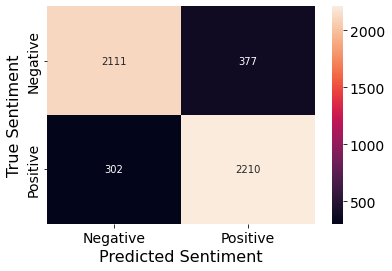

In [23]:
cm = confusion_matrix(y_test, lr_model.predict(X_test_vect))
sns.heatmap(cm, annot = True, fmt = ".0f", xticklabels = ["Negative", "Positive"],  yticklabels = ["Negative", "Positive"])
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.show()

## Testing the model on separate test data

In [24]:
test_df = pd.read_csv("testData.tsv.zip", delimiter = "\t", header = 0, doublequote = False, escapechar = "\\")
test_df.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [25]:
test_len = test_df["review"].apply(len)

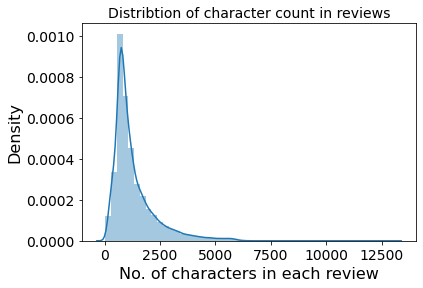

In [26]:
sns.distplot(test_len)
plt.xlabel("No. of characters in each review")
plt.title("Distribtion of character count in reviews")
plt.show()

In [27]:
test_df["num_words"] = test_df["review"].apply(lambda x: len(x.split()))

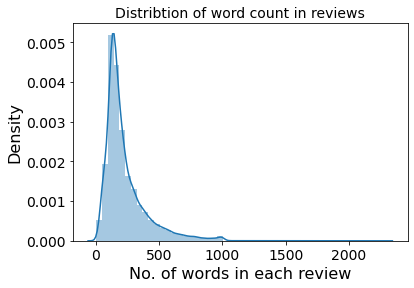

In [28]:
sns.distplot(test_df["num_words"])
plt.xlabel("No. of words in each review")
plt.title("Distribtion of word count in reviews")
plt.show()

In [29]:
test_df["clean review"] = test_df["review"].apply(clean_text)

In [30]:
test_df.head()

,id,review,num_words,clean review
0,12311_10,Naturally in a film who's main themes are of m...,131,naturally film main theme mortality nostalgia ...
1,8348_2,This movie is a disaster within a disaster fil...,169,movie disaster within disaster film full great...
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,movie kid saw tonight child loved one point ki...
3,7186_2,Afraid of the Dark left me with the impression...,112,afraid dark left impression several different ...
4,12128_7,A very accurate depiction of small time mob li...,133,accurate depiction small time mob life filmed ...


In [31]:
test_clean_review_vect = vectorizer.transform(test_df["clean review"])

In [32]:
test_df["sentiment"] = lr_model.predict(test_clean_review_vect)

In [33]:
test_df.head()

,id,review,num_words,clean review,sentiment
0,12311_10,Naturally in a film who's main themes are of m...,131,naturally film main theme mortality nostalgia ...,1
1,8348_2,This movie is a disaster within a disaster fil...,169,movie disaster within disaster film full great...,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,movie kid saw tonight child loved one point ki...,1
3,7186_2,Afraid of the Dark left me with the impression...,112,afraid dark left impression several different ...,1
4,12128_7,A very accurate depiction of small time mob li...,133,accurate depiction small time mob life filmed ...,1


## Saving the model

We will use pickle library to store/save the model, so that we can use it later as well. This way we don't need to train the model again, we can just load the trained model and use it.

In [34]:
with open("imdb_review_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)